<a href="https://colab.research.google.com/github/brendaFlavia/DeepLearningAssignment/blob/main/LungOpacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import glob
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, utils, losses, callbacks
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, accuracy_score, roc_auc_score

In [2]:
data_dir = "/content/gdrive/MyDrive/DeepLearning/dataset1"
#test_data_dir = "/content/gdrive/MyDrive/dataset1/known_images"
#validation_dir="/content/gdrive/MyDrive/dataset1/known_images"

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

import pathlib
#train and Validation data directory 
data_dir = pathlib.Path('/content/gdrive/My Drive/DeepLearning/Dataset1') 

#test data directory
test_data_dir = pathlib.Path('/content/gdrive/My Drive/DeepLearning/unknown_images') 



Mounted at /content/gdrive


In [98]:
img_width, img_height = 100,100
batch_size = 10

In [99]:
# Define image data generators
# Train data


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 715 files belonging to 2 classes.
Using 572 files for training.


In [6]:
# Test generator
#test_generator = image.ImageDataGenerator(rescale=1./255)

In [100]:
# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 715 files belonging to 2 classes.
Using 143 files for validation.


In [8]:
#test dataset


In [101]:
#batch_size=10
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=50
  )


Found 50 files belonging to 1 classes.


In [102]:
# Load class names for the dataset
class_names = val_ds.class_names
print(class_names)

['normal', 'sick']


In [11]:
#Virtualize the training dataset

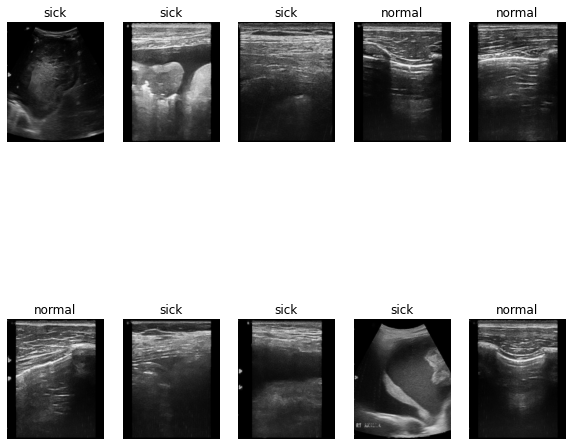

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
#print shape the training dataset

In [103]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 100, 100, 3)
(10,)


In [15]:
#print shape of test dataset

In [104]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(50, 100, 100, 3)
(50,)


In [17]:
#print shape of validation dataset

In [105]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 100, 100, 3)
(10,)


In [19]:
#normalize the dataset

In [20]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[8]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8431174


In [22]:
normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[1]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9490197


In [23]:
normalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[20]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9873527


In [24]:
#configure dataset for performance

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [26]:
#create a model
model = models.Sequential()

In [27]:
num_classes = num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes,activation='sigmoid')
])

In [28]:
#complie the model

In [29]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

#model.summary()

In [30]:
#fit the model with training dataset

In [31]:
result=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


58/58 [==============================] - 148s 3s/step - loss: 0.3710 - accuracy: 0.8287 - val_loss: 0.1354 - val_accuracy: 0.9580
Epoch 2/5
58/58 [==============================] - 133s 2s/step - loss: 0.0906 - accuracy: 0.9685 - val_loss: 0.2665 - val_accuracy: 0.9161
Epoch 3/5
58/58 [==============================] - 132s 2s/step - loss: 0.0522 - accuracy: 0.9790 - val_loss: 0.7541 - val_accuracy: 0.8531
Epoch 4/5
58/58 [==============================] - 134s 2s/step - loss: 0.0546 - accuracy: 0.9738 - val_loss: 0.0995 - val_accuracy: 0.9720
Epoch 5/5
58/58 [==============================] - 134s 2s/step - loss: 0.0084 - accuracy: 0.9983 - val_loss: 0.4759 - val_accuracy: 0.9231


In [32]:


test_loss, test_acc = model.evaluate(val_ds, verbose=2)



15/15 - 8s - loss: 0.4759 - accuracy: 0.9231 - 8s/epoch - 540ms/step


In [33]:
#Visualize training results

Text(0.5, 1.0, 'Training and Validation Accuracy')

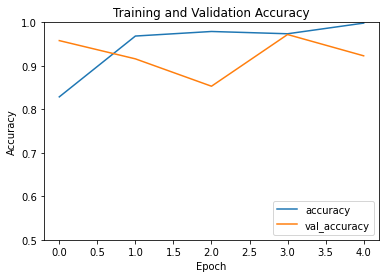

In [34]:
plt.plot(result.history['accuracy'], label='accuracy')
plt.plot(result.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [35]:
#print accauracy

In [36]:
print(test_acc)

0.9230769276618958


Text(0.5, 1.0, 'Training and Validation Loss')

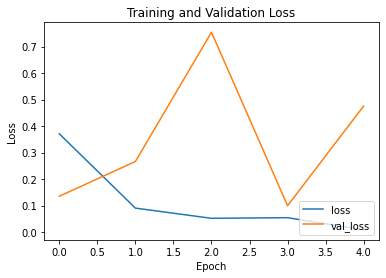

In [37]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [38]:
#Test the model

In [39]:
#load test data

In [40]:
from google.colab import drive
drive.mount('/content/gdrive')

import pathlib
test_data_dir = pathlib.Path('/content/gdrive/My Drive/DeepLearning/unknown_images') 



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Predictions:
 [1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1
 0 1 1 1 0 0 1 0 0 1 0 0 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


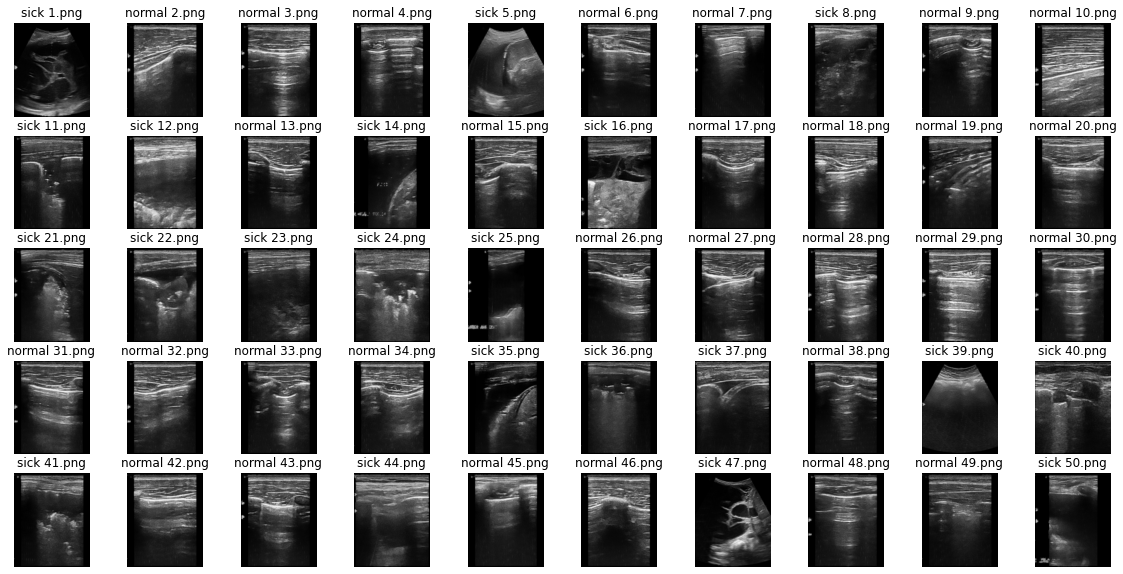

In [41]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,1)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 10))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]]+ ' '+ str(i+1)+'.png')
  plt.axis("off")

In [42]:
#Introduce Data Augumentation

In [43]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [44]:
#visualize augumented images

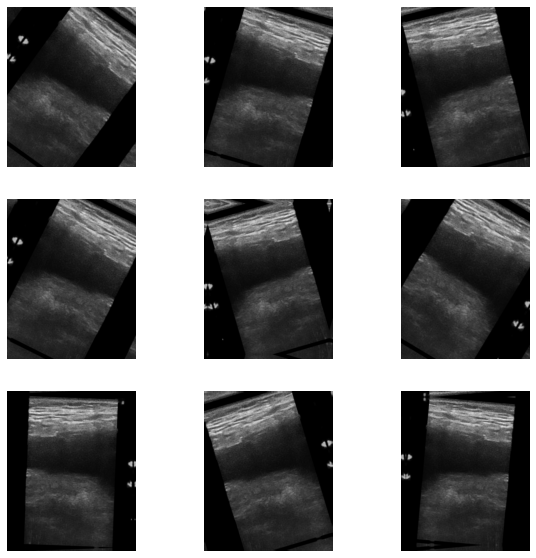

In [45]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [46]:
#Build model with data augumentation

In [47]:

model = tf.keras.Sequential([
    data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [48]:
#complie model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 488, 391, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 488, 391, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 486, 389, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 243, 194, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 241, 192, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 120, 96, 32)      0         
 2D)                                                  

In [49]:
#fit the model

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
58/58 [==============================] - 155s 3s/step - loss: 0.5023 - accuracy: 0.7727 - val_loss: 0.2364 - val_accuracy: 0.8881
Epoch 2/15
58/58 [==============================] - 150s 3s/step - loss: 0.3180 - accuracy: 0.8741 - val_loss: 0.1931 - val_accuracy: 0.9161
Epoch 3/15
58/58 [==============================] - 150s 3s/step - loss: 0.2596 - accuracy: 0.9003 - val_loss: 0.1960 - val_accuracy: 0.9091
Epoch 4/15
58/58 [==============================] - 156s 3s/step - loss: 0.2335 - accuracy: 0.8934 - val_loss: 0.1875 - val_accuracy: 0.9231
Epoch 5/15
58/58 [==============================] - 151s 3s/step - loss: 0.2456 - accuracy: 0.8864 - val_loss: 0.2178 - val_accuracy: 0.8881
Epoch 6/15
58/58 [==============================] - 148s 3s/step - loss: 0.2116 - accuracy: 0.9178 - val_loss: 0.1270 - val_accuracy: 0.9510
Epoch 7/15
58/58 [==============================] - 150s 3s/step - loss: 0.1945 - accuracy: 0.9126 - val_loss: 0.2520 - val_accuracy: 0.8881
Epoch 8/15
58

In [50]:
#Visualizing results after adding data augumentation

In [51]:
print(test_acc)

0.9230769276618958


Text(0.5, 1.0, 'Training and Validation Accuracy')

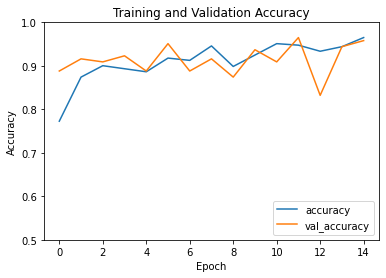

In [52]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

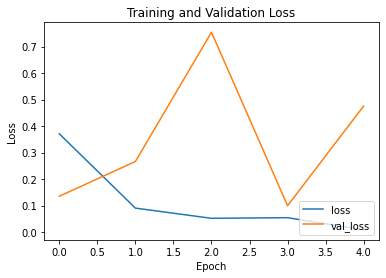

In [53]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [54]:
#using drop out to reduce overfitting the model

In [55]:
model = tf.keras.Sequential([
    data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [56]:
#complie model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 488, 391, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 488, 391, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 486, 389, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 243, 194, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 241, 192, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 120, 96, 32)      0         
 2D)                                                  

In [57]:
#test model

#fit the model

epochs = 25
history_t = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
58/58 [==============================] - 151s 3s/step - loss: 0.5701 - accuracy: 0.7570 - val_loss: 0.2464 - val_accuracy: 0.9021
Epoch 2/25
58/58 [==============================] - 149s 3s/step - loss: 0.3414 - accuracy: 0.8619 - val_loss: 0.2803 - val_accuracy: 0.8671
Epoch 3/25
58/58 [==============================] - 151s 3s/step - loss: 0.3262 - accuracy: 0.8654 - val_loss: 0.3147 - val_accuracy: 0.8671
Epoch 4/25
58/58 [==============================] - 151s 3s/step - loss: 0.2656 - accuracy: 0.8864 - val_loss: 0.1716 - val_accuracy: 0.9091
Epoch 5/25
58/58 [==============================] - 151s 3s/step - loss: 0.2516 - accuracy: 0.8969 - val_loss: 0.2799 - val_accuracy: 0.8881
Epoch 6/25
58/58 [==============================] - 148s 3s/step - loss: 0.2531 - accuracy: 0.8969 - val_loss: 0.1893 - val_accuracy: 0.9231
Epoch 7/25
58/58 [==============================] - 150s 3s/step - loss: 0.2209 - accuracy: 0.9073 - val_loss: 0.1538 - val_accuracy: 0.9510
Epoch 8/25
58

Predictions:
 [0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1
 1 0 0 1 1 1 1 1 1 0 1 0 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


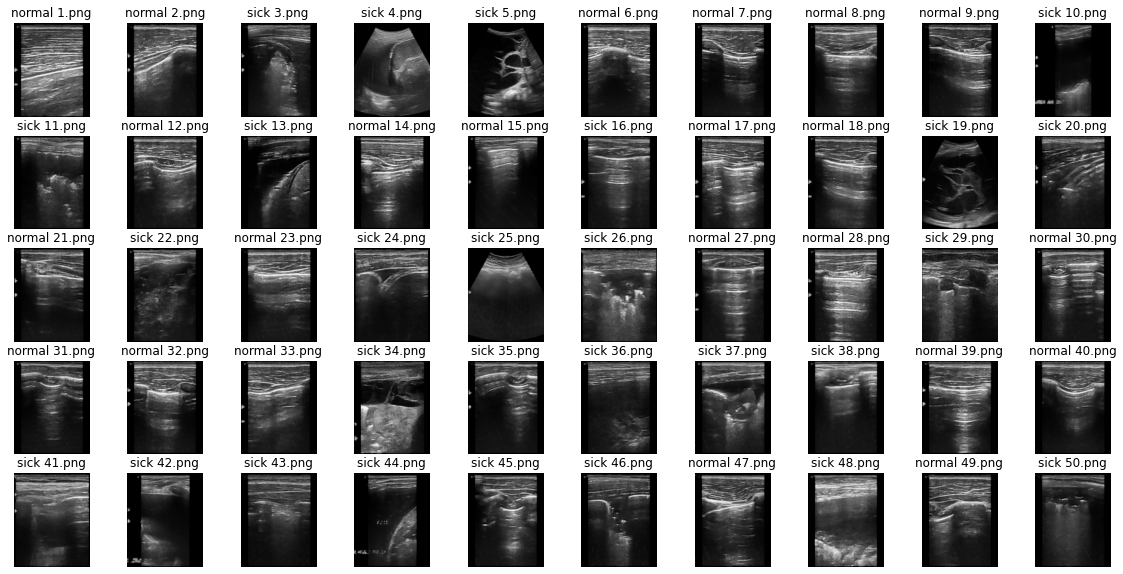

In [58]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,1)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 10))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]]+ ' '+ str(i+1)+'.png')
  plt.axis("off")

In [59]:


# dataset two

In [76]:
from google.colab import drive
drive.mount('/content/gdrive')

dataset2 = pathlib.Path('/content/gdrive/My Drive/DeepLearning/Dataset2/images/sick_eff0.png')
test_data2 = pathlib.Path('/content/gdrive/My Drive/DeepLearning/Dataset2') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [61]:
#prdict the class of images in dataset 2

In [92]:
test_ds2 = tf.keras.utils.image_dataset_from_directory(
  test_data2,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=10
  )

Found 224 files belonging to 1 classes.


In [84]:
normalized_ds1 = test_ds2.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds1))
first_image = image_batch[1]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.65882355


Predictions:
 [1 1 1 1 1 1 0 1 1 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0]
(488, 391, 3)


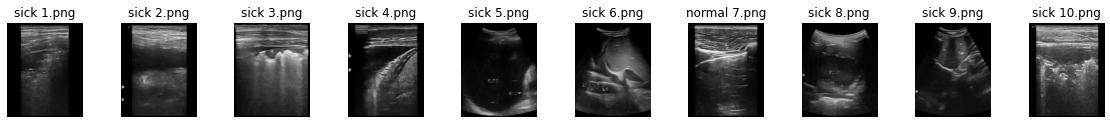

In [97]:
image_batch1, label_batch1 = test_ds2.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch1)

# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,1)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch1)

plt.figure(figsize=(20, 10))
for i in range(10):
  ax = plt.subplot(5, 10, i + 1)
  plt.imshow(image_batch1[i].astype("uint8"))
  plt.title(class_names[predictions[i]]+ ' '+ str(i+1)+'.png')
  plt.axis("off")
print (image_batch1[9].shape)

In [87]:
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#dataset2 = pathlib.Path('/content/gdrive/My Drive/DeepLearning/Dataset2/images/sick_eif30.png') 
dataset2 = pathlib.Path('/content/gdrive/My Drive/DeepLearning/Dataset2/images/sick_eff30.png') 

#image_path = tf.keras.utils.get_file('Known_image', origin=dataset2)

img = tf.keras.utils.load_img(
    dataset2, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sick with a 99.98 percent confidence.


In [88]:
train_loss, train_acc = model.evaluate(train_ds, verbose=2)

58/58 - 44s - loss: 0.0928 - accuracy: 0.9720 - 44s/epoch - 763ms/step


In [89]:
print(train_loss)

0.09281564503908157


In [90]:
print(train_acc)

0.9720279574394226


In [ ]:
#Accuracy on Dataset 2

In [94]:
test_loss1, test_acc1 = model.evaluate(test_ds2, verbose=2)

23/23 - 13s - loss: 7.8370 - accuracy: 0.0625 - 13s/epoch - 565ms/step


In [95]:
print(test_acc1)

0.0625
